# Selecting the Most Efficient Method for a Biological Optimization Problem using Deep Bidirectional Encoder Representations from Transformers (BERT)
Designed to automatically select between deterministic and heuristic methods of solving a biological optimization problem, CutFree, using the BERT unsupervised model architecture.

## Import Dependencies

In [1]:
# system
import os
import csv

# data analysis
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from sklearn.metrics import accuracy_score, classification_report, \
    confusion_matrix, ConfusionMatrixDisplay

# deep learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, TFDistilBertModel, AdamWeightDecay
from numba import cuda

# check device
device = cuda.get_current_device()
device.reset()

## Create Directory Path to Save Model Information

In [2]:
# get previous model version
highest_model_number = 0
for directory in os.listdir("models"):
    model_number = int(directory.split("-V")[-1])
    if model_number >= highest_model_number:
        highest_model_number = model_number + 1

# create save directory
save_folder = "models/AlgorithmClassifier-V" + str(highest_model_number)
save_folder

'models/AlgorithmClassifier-V1'

## Clean Dataset to Include Target

In [3]:
# read in data to dataframe
file_path = "../runtime-simulations/runtime_data.csv"
df_original = pd.read_csv(file_path)
df = df_original.copy()

# drop duplicate rows
duplicate_rows = df.duplicated(subset=["Oligo", "Sites"], keep="first")
df = df[~duplicate_rows]

# fix the sites column
df["Sites"] = [s[5:-2] for s in df["Sites"]]
df["Sites"] = [s.replace("\"", "").replace(" ", "") for s in df["Sites"]]
df["Sites"] = [s.split(",") for s in df["Sites"]]

# add time discrepancy column
df["Discrepancy"] = df["CutFree_Time"] - df["CutFreeRL_Time"]
df = df.sort_values(by=["Discrepancy"], ascending=True)
df = df.reset_index(drop=True)

# add correct algorithm column
conditions = [
    (df["CutFree_Time"] <= df["CutFreeRL_Time"]),
    (df["CutFree_Time"] > df["CutFreeRL_Time"])
]
values = [0, 1] # 0 = CutFree, 1 = CutFreeRL
df["Algorithm"] = np.select(conditions, values)

# adjust correct algorithm based on degeneracy if it outside of the confidence 
# interval (i.e., ignore CutFreeRL if the degeneracy loss is too significant, 
# typically caused by incomplete CutFreeRL output)
df.loc[df["CutFree_Degeneracy"] == 0, "Algorithm"] = 1
df.loc[
    df["CutFreeRL_Degeneracy"] <= df["CutFree_Degeneracy"]
    - (df["CutFree_Degeneracy"] * 0.10),
    "Algorithm"
] = 0

# count classifcations
print(df["Algorithm"].value_counts())

df.shape, df.iloc[0]

Algorithm
0    20680
1     6654
Name: count, dtype: int64


((27334, 14),
 Unnamed: 0                                                          12114
 Oligo                             NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
 OligoLength                                                            39
 Sites                   [CGGWCCG, CCTNAGC, CACCTGC, GGTNACC, CASTGNN, ...
 TotalSites                                                             10
 SiteLength                                                              7
 CutFree_Randomer                  NNNNHWHDWNNNNWHDWDNNNDHWHDWNNNNWHDWNNNN
 CutFree_Degeneracy                                              45.068118
 CutFree_Time                                                      0.93772
 CutFreeRL_Randomer                WKHKHBHBHHNWHNWWWDWYVBBWNDANNRNWHDWNNNN
 CutFreeRL_Degeneracy                                            39.353041
 CutFreeRL_Time                                                   4.842045
 Discrepancy                                                     -3.904324
 Algorithm 

## Get Train, Validation, and Test Data

In [4]:
# gather text and label information for tokenization
texts = []
labels = []
for index, row in df.iterrows():
    temp_text = []
    for site in row["Sites"]:
        if len(site) < 10:
            site = site + " " * (10 - len(site))
        temp_text.append(site)

    if len(temp_text) < 10:
        temp_text += [" " * 10] * (10 - len(temp_text))
        
    oligo_length = row["OligoLength"]
    if oligo_length < 10:
        oligo_length = "0" + str(oligo_length)
    temp_text.append(str(oligo_length))

    number_of_sites = row["TotalSites"]
    if number_of_sites < 10:
        number_of_sites = "0" + str(number_of_sites)
    temp_text.append(str(number_of_sites))

    site_length = row["SiteLength"]
    if site_length < 10:
        site_length = "0" + str(site_length)
    temp_text.append(str(site_length))

    texts.append("".join(temp_text))
    labels.append(row["Algorithm"])

texts[1000], labels[1000]

('RGGWCCY   CASTGNN   CACCTGC                                                                         300307',
 0)

In [5]:
# get random state to improve validity of results
random_state = np.random.randint(0, 1000)

# load train, validation, and test data for text
x_train, x_val, y_train, y_val = train_test_split(
    texts, 
    labels, 
    test_size=0.3, 
    random_state=random_state
)
x_val, x_test, y_val, y_test = train_test_split(
    x_val, 
    y_val, 
    test_size=0.4, 
    random_state=random_state
)

print("Random State: ", random_state)
print(
    "Train, Validation, and Test Sizes: ", 
    len(x_train), 
    len(x_val), 
    len(x_test)
)

Random State:  660
Train, Validation, and Test Sizes:  19133 4920 3281


In [6]:
# get train, val, and test data
x_train_oligo_lengths = []
x_train_number_of_sites = []
x_train_site_lengths = []
for x in x_train:
    x_train_oligo_lengths.append(int(x[-6:-4]))
    x_train_number_of_sites.append(int(x[-4:-2]))
    x_train_site_lengths.append(int(x[-2:]))

x_val_oligo_lengths = []
x_val_number_of_sites = []
x_val_site_lengths = []
for x in x_val:
    x_val_oligo_lengths.append(int(x[-6:-4]))
    x_val_number_of_sites.append(int(x[-4:-2]))
    x_val_site_lengths.append(int(x[-2:]))

x_test_oligo_lengths = []
x_test_number_of_sites = []
x_test_site_lengths = []
for x in x_test:
    x_test_oligo_lengths.append(int(x[-6:-4]))
    x_test_number_of_sites.append(int(x[-4:-2]))
    x_test_site_lengths.append(int(x[-2:]))

# make tensors for train, validation, and test data
tf_train = tf.convert_to_tensor(
    (x_train_oligo_lengths)
)

tf_val = tf.convert_to_tensor(
    (x_val_oligo_lengths)
)

tf_test = tf.convert_to_tensor(
    (x_test_oligo_lengths)
)

# drop last 6 characters from each text
x_train = [x[:-6] for x in x_train]
x_val = [x[:-6] for x in x_val]
x_test = [x[:-6] for x in x_test]

In [7]:
# convert string of sites to list of sites
x_train_list = []
for x in x_train:
    x_train_temp = []
    for i in range(0, len(x), 10):
        x_train_temp.append(x[i:i+10])
    x_train_list.append(x_train_temp)

x_val_list = []
for x in x_val:
    x_val_temp = []
    for i in range(0, len(x), 10):
        x_val_temp.append(x[i:i+10])
    x_val_list.append(x_val_temp)

x_test_list = []
for x in x_test:
    x_test_temp = []
    for i in range(0, len(x), 10):
        x_test_temp.append(x[i:i+10])
    x_test_list.append(x_test_temp)

## Tokenize Input Sequences

In [8]:
# constants
MAX_LENGTH = 100
BATCH_SIZE = 64
BERT_MODEL_NAME = "distilbert-base-uncased"

# initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL_NAME)

# tokenize training data
tokens_train = tokenizer(
    x_train, 
    padding="max_length",
    truncation=True,
    max_length=MAX_LENGTH,
    return_tensors="tf"
)

input_ids_train = tokens_train["input_ids"]
attention_mask_train = tokens_train["attention_mask"]

texts_train = (input_ids_train, attention_mask_train, tf_train)
labels_train = tf.constant(y_train)

# tokenize validation data
tokens_val = tokenizer.batch_encode_plus(
    x_val, 
    padding="max_length",
    truncation=True,
    max_length=MAX_LENGTH,
    return_tensors="tf"
)

input_ids_val = tokens_val["input_ids"]
attention_mask_val = tokens_val["attention_mask"]

texts_val = (input_ids_val, attention_mask_val, tf_val)
labels_val = tf.constant(y_val)

texts_train

(<tf.Tensor: shape=(19133, 100), dtype=int32, numpy=
 array([[  101, 10507, 13535, ...,     0,     0,     0],
        [  101, 10507,  2102, ...,     0,     0,     0],
        [  101,  1043, 18195, ...,     0,     0,     0],
        ...,
        [  101, 10507,  2102, ...,     0,     0,     0],
        [  101, 10507, 27767, ...,     0,     0,     0],
        [  101,  1043,  6593, ...,     0,     0,     0]])>,
 <tf.Tensor: shape=(19133, 100), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]])>,
 <tf.Tensor: shape=(19133,), dtype=int32, numpy=array([31, 34, 33, ..., 17,  6, 24])>)

## Compile, Train, and Save Model

In [9]:
# input layers
input_ids = tf.keras.layers.Input(
    shape=(MAX_LENGTH,), 
    name="input_ids", 
    dtype="int32"
)
attention_mask = tf.keras.layers.Input(
    shape=(MAX_LENGTH,), 
    name="attention_mask", 
    dtype="int32"
)
int_inputs = tf.keras.layers.Input(
    shape=(1,),
    name="int_inputs",
    dtype="float32"
)

# bert model
bert_model = TFDistilBertModel.from_pretrained(
    BERT_MODEL_NAME, 
    output_attentions=False, 
    output_hidden_states=False
)([input_ids, attention_mask])
bert_output = bert_model.last_hidden_state[:, 0, :]

# mlp layers
bert_mlp = tf.keras.Sequential([
    tf.keras.layers.Dropout(0.8, name="dropout_0"),
    tf.keras.layers.Dense(
        768, 
        kernel_regularizer = tf.keras.regularizers.L1L2(1e-2),
        bias_regularizer = tf.keras.regularizers.L1L2(1e-2),
        activity_regularizer = tf.keras.regularizers.L1L2(1e-2),
        name="dense_1"
    ),
    tf.keras.layers.BatchNormalization(name="batch_norm_1"),
    tf.keras.layers.Dropout(0.4, name="dropout_1"),
    tf.keras.layers.Activation("relu", name="relu_1"),

    tf.keras.layers.Dense(
        128, 
        kernel_regularizer = tf.keras.regularizers.L1L2(1e-2),
        bias_regularizer = tf.keras.regularizers.L1L2(1e-2),
        activity_regularizer = tf.keras.regularizers.L1L2(1e-2),
        name="dense_2"
    ),
    tf.keras.layers.BatchNormalization(name="batch_norm_2"),
    tf.keras.layers.Dropout(0.4, name="dropout_2"),
    tf.keras.layers.Activation("relu", name="relu_2"),

    tf.keras.layers.Dense(
        64, 
        kernel_regularizer = tf.keras.regularizers.L1L2(1e-2),
        bias_regularizer = tf.keras.regularizers.L1L2(1e-2),
        activity_regularizer = tf.keras.regularizers.L1L2(1e-2),
        name="dense_3"
    ),
    tf.keras.layers.BatchNormalization(name="batch_norm_3"),
    tf.keras.layers.Dropout(0.4, name="dropout_3"),
    tf.keras.layers.Activation("relu", name="relu_3")
], name="bert_mlp")(bert_output)

int_mlp = tf.keras.Sequential([
    tf.keras.layers.Dense(
        128, 
        kernel_regularizer = tf.keras.regularizers.L1L2(1e-2),
        bias_regularizer = tf.keras.regularizers.L1L2(1e-2),
        activity_regularizer = tf.keras.regularizers.L1L2(1e-2),
        name="dense_1_oligo"
    ),
    tf.keras.layers.BatchNormalization(name="batch_norm_1_oligo"),
    tf.keras.layers.Dropout(0.4, name="dropout_1_oligo"),
    tf.keras.layers.Activation("relu", name="relu_1_oligo"),

    tf.keras.layers.Dense(
        64, 
        kernel_regularizer = tf.keras.regularizers.L1L2(1e-2),
        bias_regularizer = tf.keras.regularizers.L1L2(1e-2),
        activity_regularizer = tf.keras.regularizers.L1L2(1e-2),
        name="dense_2_oligo"
    ),
    tf.keras.layers.BatchNormalization(name="batch_norm_2_oligo"),
    tf.keras.layers.Dropout(0.4, name="dropout_2_oligo"),
    tf.keras.layers.Activation("relu", name="relu_2_oligo")
], name="oligo_mlp")(int_inputs)

# concatenate bert and oligo outputs
concatenate = tf.keras.layers.concatenate(
    [bert_mlp, int_mlp], 
    name="concatenate"
)

# output layer
output = tf.keras.layers.Dense(
    2, 
    activation="softmax", 
    name="output"
)(concatenate)

# combine input and output layers to create model
model = tf.keras.Model(
    inputs=[input_ids, attention_mask, int_inputs], 
    outputs=output, 
    name="AlgorithmClassifier"
)

model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "AlgorithmClassifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 100, 768),                                                   
                                 hidden_states=None                             

In [10]:
# create optimizer and loss function
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# compile model
model.compile(optimizer, loss, metrics=["accuracy"])

# class weights (if not balanced)
class_weights = dict(
    enumerate(
        compute_class_weight(
            class_weight="balanced", 
            classes=np.unique(y_train), 
            y=np.array(y_train)
        )
    )
)

# callbacks for early stopping, saving checkpoints, and tensorboard
model_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=save_folder 
        + "/checkpoints/model.{epoch:02d}-{val_accuracy:.3f}.h5"
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=save_folder + "/checkpoints/best_model.h5",
        monitor='val_loss', 
        save_best_only=True
    ),
    tf.keras.callbacks.TensorBoard(log_dir=save_folder + "/logs")
]

# fine-tune model to training data
history = model.fit(
    texts_train,
    labels_train,
    validation_data=(texts_val, labels_val), 
    epochs=100, 
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=model_callbacks
)

Epoch 1/100
299/299 [==============================] - 132s 406ms/step - loss: 199.8758 - accuracy: 0.3730 - val_loss: 154.6114 - val_accuracy: 0.5774
Epoch 2/100
299/299 [==============================] - 120s 401ms/step - loss: 120.3360 - accuracy: 0.5686 - val_loss: 87.3078 - val_accuracy: 0.7512
Epoch 3/100
299/299 [==============================] - 120s 402ms/step - loss: 64.0759 - accuracy: 0.6933 - val_loss: 42.8449 - val_accuracy: 0.8648
Epoch 4/100
299/299 [==============================] - 120s 400ms/step - loss: 30.6992 - accuracy: 0.7471 - val_loss: 20.7846 - val_accuracy: 0.8919
Epoch 5/100
299/299 [==============================] - 120s 401ms/step - loss: 17.2832 - accuracy: 0.7829 - val_loss: 14.0845 - val_accuracy: 0.8886
Epoch 6/100
299/299 [==============================] - 120s 401ms/step - loss: 12.4119 - accuracy: 0.8043 - val_loss: 10.2851 - val_accuracy: 0.8953
Epoch 7/100
299/299 [==============================] - 121s 403ms/step - loss: 9.2588 - accuracy: 0.815

In [11]:
int_outputs = tf.keras.layers.Dense(
    2,
    activation="softmax",
    name="int_outputs"
)(int_mlp)

model_2 = tf.keras.Model(
    inputs=int_inputs,
    outputs=int_outputs,
    name="AlgorithmClassifier_2"
)

model_2.summary()

Model: "AlgorithmClassifier_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 int_inputs (InputLayer)     [(None, 1)]               0         
                                                                 
 oligo_mlp (Sequential)      (None, 64)                9280      
                                                                 
 int_outputs (Dense)         (None, 2)                 130       
                                                                 
Total params: 9,410
Trainable params: 9,026
Non-trainable params: 384
_________________________________________________________________


In [12]:
# create optimizer and loss function
optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# compile model
model_2.compile(optimizer, loss, metrics=["accuracy"])

# class weights (if not balanced)
class_weights = dict(
    enumerate(
        compute_class_weight(
            class_weight="balanced", 
            classes=np.unique(y_train), 
            y=np.array(y_train)
        )
    )
)

# callbacks for early stopping, saving checkpoints, and tensorboard
model_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=8)
]

history_2 = model_2.fit(
    tf_train,
    labels_train,
    validation_data=(tf_val, labels_val), 
    epochs=100, 
    batch_size=BATCH_SIZE,
    class_weight=class_weights,
    callbacks=model_callbacks
)

Epoch 1/100
299/299 [==============================] - 3s 7ms/step - loss: 0.5921 - accuracy: 0.6508 - val_loss: 0.5422 - val_accuracy: 0.6856
Epoch 2/100
299/299 [==============================] - 2s 7ms/step - loss: 0.5786 - accuracy: 0.6572 - val_loss: 0.5676 - val_accuracy: 0.6510
Epoch 3/100
299/299 [==============================] - 2s 7ms/step - loss: 0.5745 - accuracy: 0.6555 - val_loss: 0.5871 - val_accuracy: 0.6856
Epoch 4/100
299/299 [==============================] - 2s 7ms/step - loss: 0.5689 - accuracy: 0.6553 - val_loss: 0.5595 - val_accuracy: 0.6510
Epoch 5/100
299/299 [==============================] - 2s 8ms/step - loss: 0.5680 - accuracy: 0.6509 - val_loss: 0.6327 - val_accuracy: 0.6315
Epoch 6/100
299/299 [==============================] - 2s 7ms/step - loss: 0.5656 - accuracy: 0.6549 - val_loss: 0.5571 - val_accuracy: 0.6695
Epoch 7/100
299/299 [==============================] - 2s 7ms/step - loss: 0.5614 - accuracy: 0.6569 - val_loss: 0.5483 - val_accuracy: 0.6695

## Evaluate Model Performance

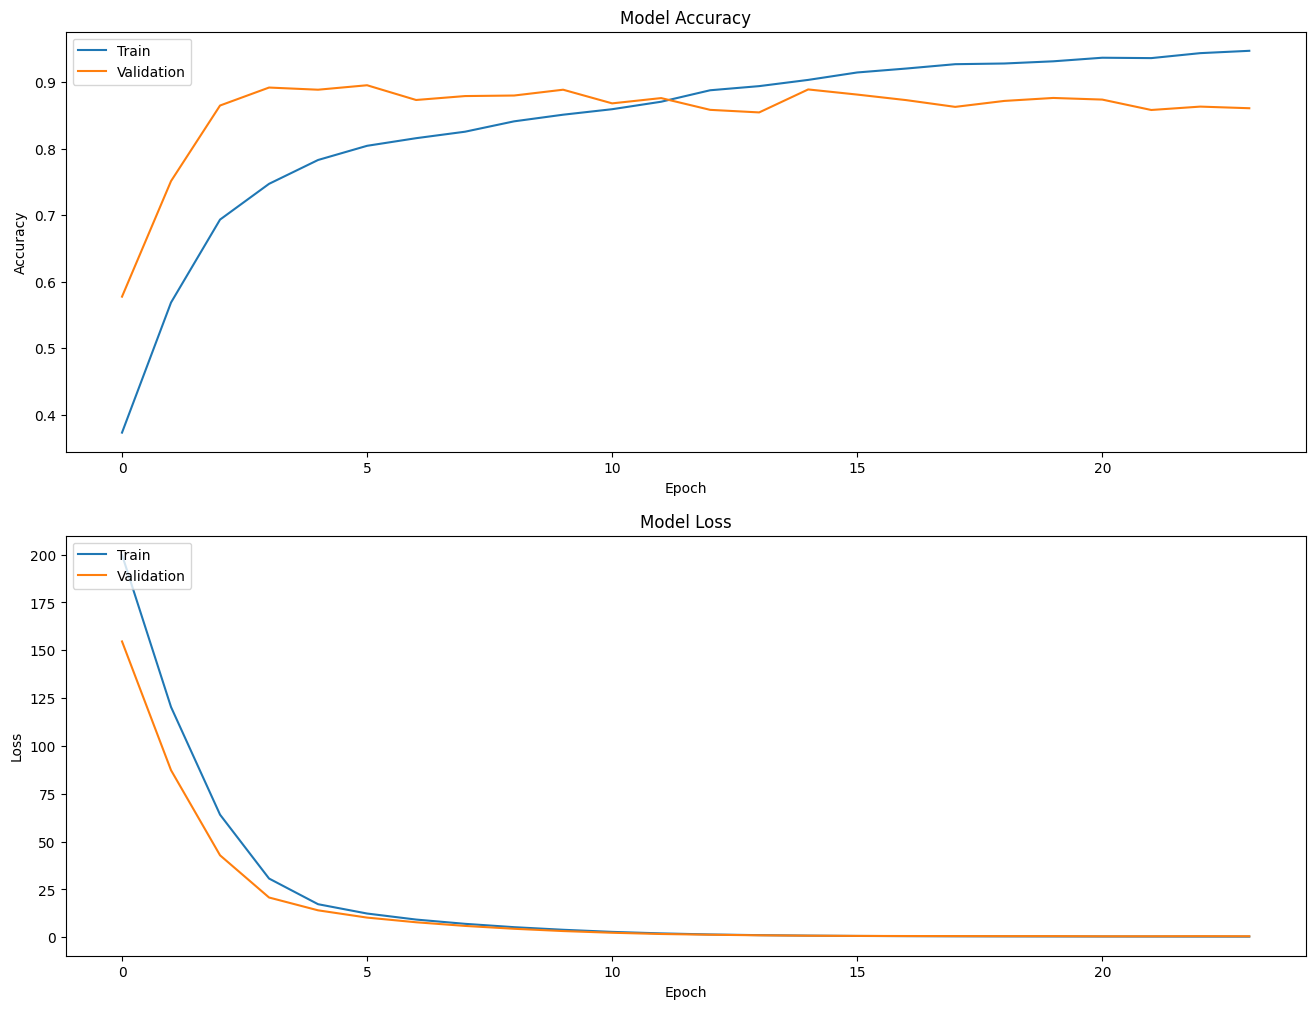

In [13]:
fig = plt.figure(figsize=(16, 12))

plt.subplot(2, 1, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

plt.subplot(2, 1, 2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

fig.savefig(save_folder + "/training.png")

In [47]:
# tokenize test data
tokens_test = tokenizer.batch_encode_plus(
    x_test, 
    padding="max_length",
    truncation=True,
    max_length=MAX_LENGTH,
    return_tensors="tf"
)

input_ids_test = tokens_test["input_ids"]
attention_mask_test = tokens_test["attention_mask"]

texts_test = (input_ids_test, attention_mask_test, tf_test)
labels_test = tf.constant(y_test)

In [48]:
# get accuracy of bert-based model
_, acc = model.evaluate(texts_test, labels_test)

# get accuracy of int-based model
_, acc_2 = model_2.evaluate(tf_test, labels_test)
    
print("BERT Model Accuracy: ", acc)
print("Integer Model Accuracy: ", acc_2)

103/103 [==============================] - 0s 3ms/step - loss: 0.5711 - accuracy: 0.6364
BERT Model Accuracy:  0.8783907294273376
Integer Model Accuracy:  0.6363913416862488


In [49]:
# load model
model = tf.keras.models.load_model(
    save_folder + "/checkpoints/best_model.h5",
    custom_objects={
        "TFDistilBertModel": TFDistilBertModel, 
        "AdamWeightDecay": AdamWeightDecay
    }
)

# get accuracy of best bert-based model
_, acc = model.evaluate(texts_test, labels_test)

print("Best BERT Model Accuracy: ", acc)

# save accuracy
with open(save_folder + "/accuracy_results.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow([acc])

103/103 [==============================] - 9s 71ms/step - loss: 0.5006 - accuracy: 0.8784
Best BERT Model Accuracy:  0.8783907294273376


In [50]:
# retrieve model predictions on test data
y_pred = model.predict(texts_test)
y_pred = np.argmax(y_pred, axis=1)

# create classification report
class_report = classification_report(
    y_pred, 
    y_test, 
    target_names=["CutFree", "CutFreeRL"]
)

# save classification report
with open(save_folder + "/classification_report.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow([class_report])
    
print(class_report)

103/103 [==============================] - 8s 67ms/step
              precision    recall  f1-score   support

     CutFree       0.89      0.95      0.92      2337
   CutFreeRL       0.84      0.71      0.77       944

    accuracy                           0.88      3281
   macro avg       0.87      0.83      0.84      3281
weighted avg       0.88      0.88      0.88      3281



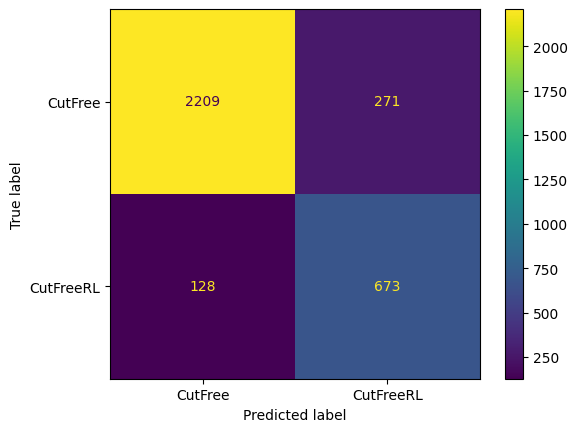

In [51]:
# create confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig = ConfusionMatrixDisplay(cm, display_labels=["CutFree", "CutFreeRL"])
fig.plot()

# save confusion matrix
plt.savefig(save_folder + "/confusion_matrix.png")

## Plot Correct Selection for CutFree and CutFreeRL

In [52]:
# set colors and font for plots
rgb = []
for _ in df[df["Algorithm"] == 0].index:
    c = [46/255, 108/255, 190/255]
    rgb.append(c)

rgb2 = []
for _ in df[df["Algorithm"] == 1].index:
    c = [220/255, 77/255, 58/255]
    rgb2.append(c)

gfont = {"fontname": "Georgia"}
font = font_manager.FontProperties(family="Georgia", style="normal", size=32)

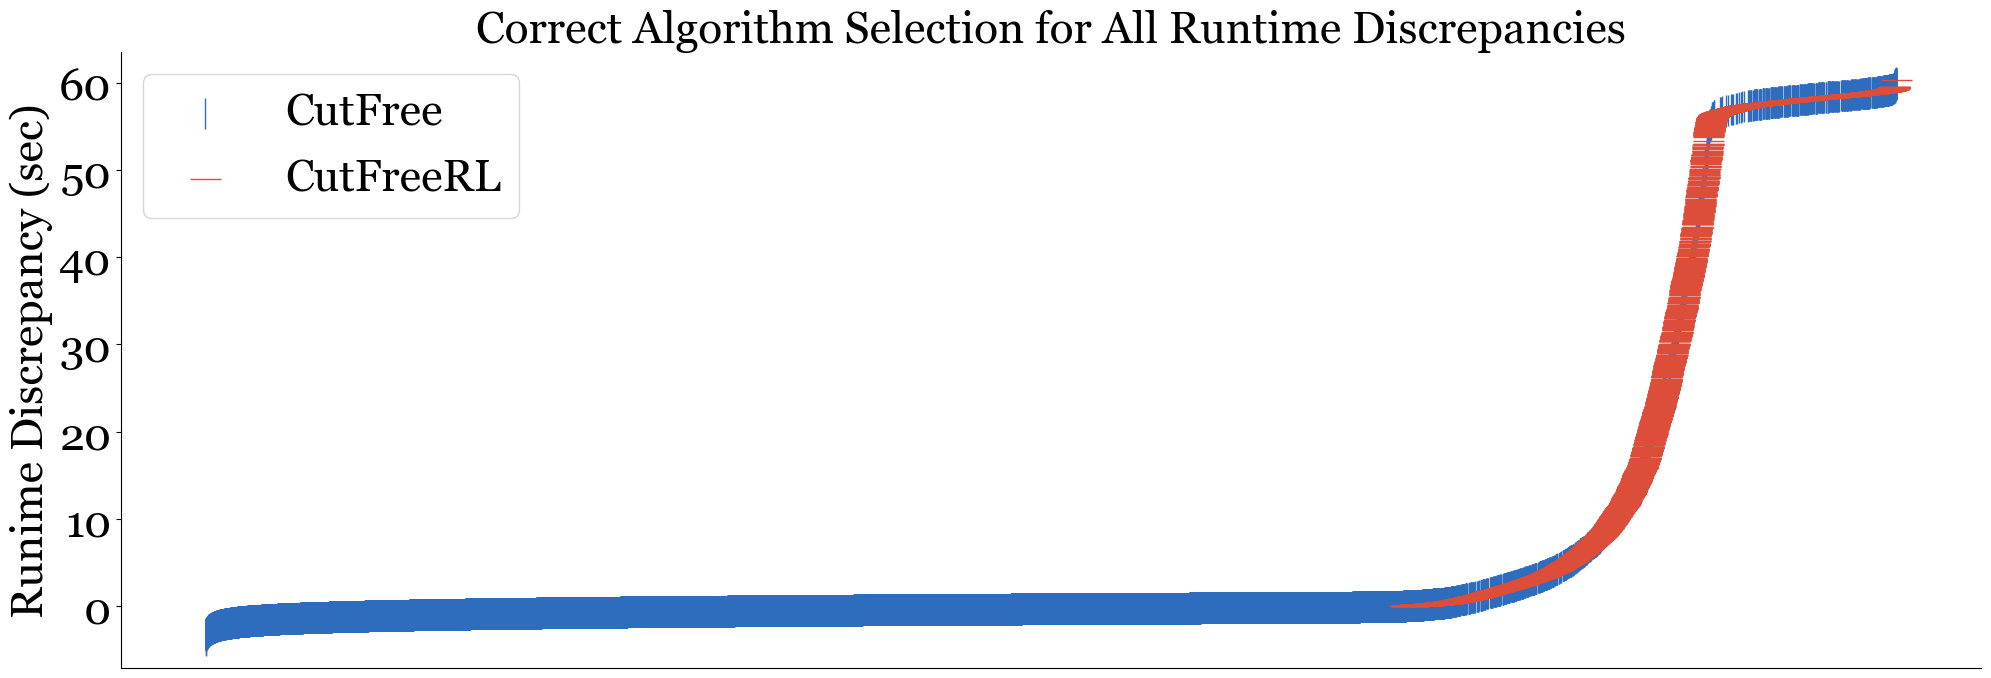

In [53]:
plt.figure(figsize=(24, 8))

# plot expected algorithm selection for all time discrepencies
plt.scatter(
    df[df["Algorithm"] == 0].index, df[df["Algorithm"] == 0]["Discrepancy"], 
    c=rgb,
    linewidths=1,
    marker="|",
    s=500
)
plt.scatter(
    df[df["Algorithm"] == 1].index, df[df["Algorithm"] == 1]["Discrepancy"], 
    c=rgb2,
    linewidths=1,
    marker="_",
    s=500
)
    
plt.title(
    "Correct Algorithm Selection for All Runtime Discrepancies", 
    fontsize=32, 
    **gfont
)
plt.ylabel("Runime Discrepancy (sec)", fontsize=32, **gfont)
plt.legend(["CutFree", "CutFreeRL"], prop=font)
ax = plt.gca()
plt.xticks(fontsize=32, **gfont)
plt.yticks(fontsize=32, **gfont)
ax.get_xaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.savefig(save_folder + "/correct_algorithm_selection.png")

## Plot Predictions for Selection of CutFree and CutFreeRL

In [54]:
# organize test data for analysis
x_test = np.array(x_test)

# get oligos from test inputs
x_test_oligos = ["N" * x for x in x_test_oligo_lengths]

# get sites from test inputs
x_test_sites = []
for x in x_test:
    temp_sites = [x[i:i+10] for i in range(0, 100, 10)]
    temp_sites = [s.replace(" ", "") for s in temp_sites]
    temp_sites = list(filter(None, temp_sites))
    x_test_sites.append(temp_sites)

print(len(x_test_oligos), len(x_test_sites), len(y_test))

3281 3281 3281


In [55]:
# copy dataframe
df_test = df.copy()

# add prediction column using test data
for oligo, site, pred, test in zip(x_test_oligos, x_test_sites, y_pred, y_test):
    for index, (oligo_df, sites_df) in \
        enumerate(zip(df_test["Oligo"].values, df_test["Sites"].values)):
        if (oligo == oligo_df) and (site == sites_df):
            df_test.loc[index, "Prediction"] = pred == test

# drop unassigned rows
df_test = df_test.dropna(subset=["Prediction"])

# set prediction algorithm
cutfree_condition = \
    ((df_test["Prediction"] == True) & (df_test["Algorithm"] == 0)) \
    | ((df_test["Prediction"] == False) & (df_test["Algorithm"] == 1))
cutfreerl_condition = \
    ((df_test["Prediction"] == True) & (df_test["Algorithm"] == 1)) \
    | ((df_test["Prediction"] == False) & (df_test["Algorithm"] == 0))
df_test.loc[cutfree_condition, "Prediction"] = 0
df_test.loc[cutfreerl_condition, "Prediction"] = 1

# create correct/incorrect column
df_test["Correct"] = df_test["Algorithm"] == df_test["Prediction"]

# sort dataframe by discrepency and reset index
df_test = df_test.sort_values(
    by=["Discrepancy"], 
    ascending=True
).reset_index(drop=True)

# check prediction column
df_test["Prediction"].value_counts() # 0 = CutFree, 1 = CutFreeRL

Prediction
0    2337
1     944
Name: count, dtype: int64

C:\Users\wrick\AppData\Local\Temp\ipykernel_22348\2349818421.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


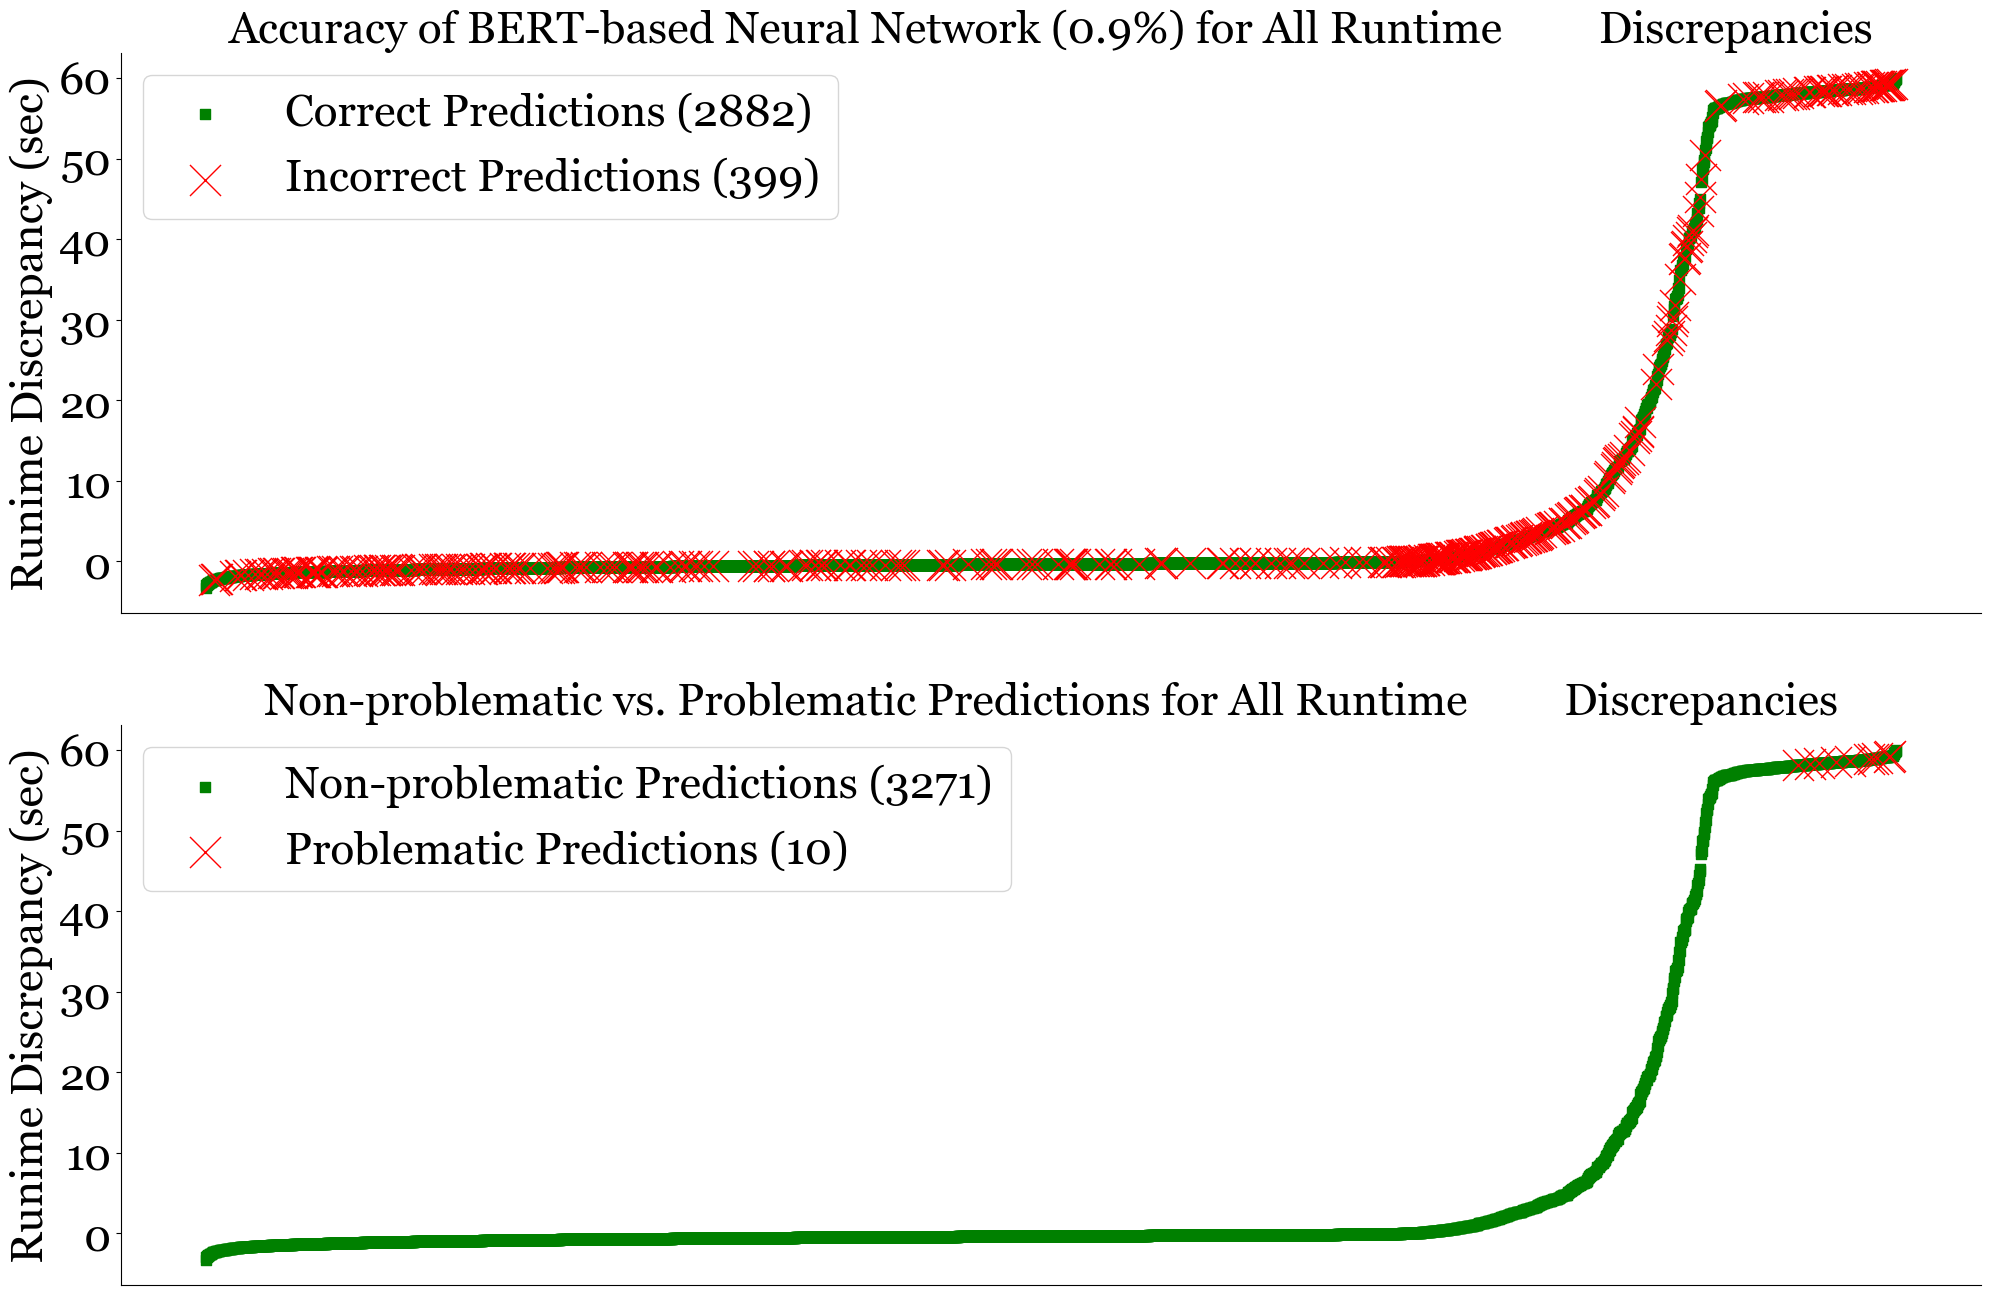

In [56]:
fig, ax = plt.subplots(figsize=(24, 16))

# plot correct and incorrect selections for all time discrepencies
plt.subplot(2, 1, 1)

correct_conditions = (df_test["Correct"] == True)
plt.scatter(
    df_test[correct_conditions].index,
    df_test.loc[correct_conditions, "Discrepancy"], 
    c="g",
    linewidths=1,
    marker="s",
    s=50)

incorrect_conditions = (df_test["Correct"] == False)
plt.scatter(
    df_test[incorrect_conditions].index,
    df_test.loc[incorrect_conditions, "Discrepancy"], 
    c="r",
    linewidths=1,
    marker="x",
    s=500)

plt.title(
    f"Accuracy of BERT-based Neural Network ({acc:.1f}%) for All Runtime \
        Discrepancies", 
    fontsize=32, 
    **gfont
)
plt.ylabel("Runime Discrepancy (sec)", fontsize=32, **gfont)
plt.legend(
    [f"Correct Predictions ({len(df_test[correct_conditions])})", 
    f"Incorrect Predictions ({len(df_test[incorrect_conditions])})"], 
    prop=font
)
ax = plt.gca()
plt.xticks(fontsize=32, **gfont)
plt.yticks(fontsize=32, **gfont)
ax.get_xaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# plot problematic selections for all time discrepencies
plt.subplot(2, 1, 2)

nonproblematic_conditions = \
    (df_test["Correct"] == True) \
    | ((df_test["Correct"] == False) & (df_test["Algorithm"] == 0)) \
    | ((df_test["Correct"] == False) & (df_test["CutFree_Time"] <= 60))
plt.scatter(
    df_test[nonproblematic_conditions].index,
    df_test.loc[nonproblematic_conditions, "Discrepancy"], 
    c="g",
    linewidths=1,
    marker="s",
    s=50
)

# problematic conditions are defined as incorrect predictions that place the 
# system at risk of runtime explosion
problematic_conditions = \
    ((df_test["Correct"] == False) \
    & (df_test["Algorithm"] == 1) \
    & (df_test["CutFree_Time"] >= 60))
plt.scatter(
    df_test[problematic_conditions].index,
    df_test.loc[problematic_conditions, "Discrepancy"], 
    c="r",
    linewidths=1,
    marker="x",
    s=500
)

plt.title(
    f"Non-problematic vs. Problematic Predictions for All Runtime \
        Discrepancies", 
    fontsize=32, 
    **gfont
)
plt.ylabel("Runime Discrepancy (sec)", fontsize=32, **gfont)
plt.legend(
    [f"Non-problematic Predictions ({len(df_test[nonproblematic_conditions])})", 
    f"Problematic Predictions ({len(df_test[problematic_conditions])})"], 
    prop=font
)
ax = plt.gca()
plt.xticks(fontsize=32, **gfont)
plt.yticks(fontsize=32, **gfont)
ax.get_xaxis().set_visible(False)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.savefig(save_folder + "/runtime_discrepancies.png")

In [57]:
# get sensitivity for values above runtime limit
sensitivity = (
    len(df_test[nonproblematic_conditions])) \
    / (len(df_test[nonproblematic_conditions]) \
    + len(df_test[problematic_conditions])
) * 100

# save sensitivity
with open(save_folder + "/sensitivity_results.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow([sensitivity])
    
sensitivity

99.69521487351417

## Get Average Model Statistics

In [58]:
# initialize values
average_sensitivity = np.array([])
average_acc = np.array([])

# retrieve all values from saved CSV files
for directory in os.listdir("models"):
    if directory.startswith("AlgorithmClassifier"):
        with open("models/" + directory + "/sensitivity_results.csv", "r") as f:
            reader = csv.reader(f)
            for row in reader:
                if len(row) > 0:
                    average_sensitivity = np.append(
                        average_sensitivity, float(row[0])
                    )
        with open("models/" + directory + "/accuracy_results.csv", "r") as f:
            reader = csv.reader(f)
            for row in reader:
                if len(row) > 0:
                    average_acc = np.append(average_acc, float(row[0]))
        n = len(average_sensitivity)

print(
    f"Average Sensitivity: {average_sensitivity.mean():.1f}% \
        +/- {average_sensitivity.std():.5f}"
)
print(
    f"Average Accuracy: {average_acc.mean():.1f}% +/- {average_acc.std():.5f}"
)
print(f"Number of Trials: {n}")

Average Sensitivity: 98.8%         +/- 0.88388
Average Accuracy: 0.9% +/- 0.02575
Number of Trials: 2


# Load Model and Make New Predictions

In [59]:
# import dependencies
import tensorflow as tf
import numpy as np
from transformers import DistilBertTokenizer, TFDistilBertModel, AdamWeightDecay

# load model
best_model = tf.keras.models.load_model(
    save_folder + "/checkpoints/best_model.h5",
    custom_objects={
        "TFDistilBertModel": TFDistilBertModel, 
        "AdamWeightDecay": AdamWeightDecay
    }
)

# load tokenizer
new_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

best_model.evaluate(texts_test, labels_test)

103/103 [==============================] - 9s 69ms/step - loss: 0.5006 - accuracy: 0.8784


[0.5006338953971863, 0.8783907294273376]

In [60]:
# get input
text_1 = "ACGWGN TTTCGGCC RTAGGCAY ACGCTTC ACGY ATTT TACG"
text_2 = "ACGWGN TTTCGGCC RTAGGCAY ACGCTTC ACGY CNNR ATTT TACG"
text_attributes = tf.transpose(
    tf.convert_to_tensor(
        ([10, 40, 40])
    )
)

new_tokens_test = new_tokenizer.batch_encode_plus(
    [text_1, text_1, text_2], 
    padding="max_length",
    truncation=True,
    max_length=100,
    return_tensors="tf"
)

new_input_ids_test = new_tokens_test["input_ids"]
new_attention_mask_test = new_tokens_test["attention_mask"]

new_texts_test = (new_input_ids_test, new_attention_mask_test, text_attributes)

# predict
new_y_pred = np.argmax(best_model.predict(new_texts_test), axis=1)

print(
    "Reconstructed Model Prediction (0 = CutFree, 1 = CutFreeRL): ", new_y_pred
)

1/1 [==============================] - 1s 1s/step
Reconstructed Model Prediction (0 = CutFree, 1 = CutFreeRL):  [0 1 0]
